In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd
import sqlalchemy

import sklearn.metrics as metrics
from tensorflow.python.data import Dataset

In [2]:
#getting movies dataset using Pandas from movie_metadata provided by Prof Zhang
movies_dataframe =  pd.read_csv("movie_metadata.csv", sep=",")

In [3]:
#getting actors dataset using Pandas from BuzzFeed
actors_dataframe = pd.read_csv("actor-metrics.csv", sep=",")

In [4]:
#renaming the lead actors column name for each table to have the same name 'lead_actors'
movies_dataframe = movies_dataframe.rename(columns={'actor_1_name': 'lead_actors'})
actors_dataframe = actors_dataframe.rename(columns={'actor': 'lead_actors'})

In [5]:
#Clean Up Part 1: Remove unnecessary columns
#First eliminate unnecessary columns and then merge, this way the table is easier to look at
#We should remove movies that are too old for us to look at!
movies_dataframe = movies_dataframe[['lead_actors', 'movie_title', 'title_year', 'gross', 'movie_facebook_likes', 'imdb_score']].query('title_year>=2010.0')
actors_dataframe = actors_dataframe[['lead_actors', 'gender', 'race_simple']]

In [6]:
#Clean Up Part 2: Merge
movies_dataframe_merged = movies_dataframe.merge(actors_dataframe,on='lead_actors')

In [7]:
#Clean Up Part 3: Remove duplicates
#remove duplicates based on the movie – even though the actors are still duplicated but they worked on different projects with different gross
movies_dataframe_noDuplicates = movies_dataframe_merged.drop_duplicates(subset=['movie_title'], keep='first', inplace=False)

In [8]:
#Clean Up Part 4: check if we have movies that still have missing gross revenue in this data
movies_dataframe_noDuplicates[np.isnan(movies_dataframe_noDuplicates.gross)]

,lead_actors,movie_title,title_year,gross,movie_facebook_likes,imdb_score,gender,race_simple
81,Morgan Freeman,Ben-Hur,2016.0,NaN,0,6.1,male,POC
95,Peter Dinklage,Destiny,2014.0,NaN,1000,8.1,male,White
97,Jim Broadbent,Animals United,2010.0,NaN,885,4.9,male,White
130,Meryl Streep,Florence Foster Jenkins,2016.0,NaN,0,7.1,female,White


In [9]:
#Clean Up Part 4: adding missing revenues to the data
#2 of these are video games – for now the revenue will be replaced with 0
missing_gross = {'Destiny': 0, 'Animals United': 0, 'Ben-Hur':26410477, 'Florence Foster Jenkins': 27383770}
for idx, row in movies_dataframe_noDuplicates[np.isnan(movies_dataframe_noDuplicates.gross)].iterrows():
    movies_dataframe_noDuplicates.at[idx, 'gross'] = missing_gross[row['movie_title'].strip()] 
    #https://stackoverflow.com/questions/10993612/python-removing-xa0-from-string

In [10]:
#Clean Up Part 4: check one more time if the NaN values are no longer in the data
movies_dataframe_noDuplicates[np.isnan(movies_dataframe_noDuplicates.gross)]

,lead_actors,movie_title,title_year,gross,movie_facebook_likes,imdb_score,gender,race_simple


In [11]:
#Clean Up Part 5: check and see movies with 0 Facebook likes
movies_dataframe_noDuplicates.query('movie_facebook_likes == 0')

,lead_actors,movie_title,title_year,gross,movie_facebook_likes,imdb_score,gender,race_simple
30,Tom Hanks,Larry Crowne,2011.0,35565975.0,0,6.1,male,White
57,Gary Oldman,Criminal,2016.0,14268533.0,0,6.3,male,White
64,Robin Williams,Happy Feet 2,2011.0,63992328.0,0,5.9,male,White
66,Robin Williams,The Big Wedding,2013.0,21784432.0,0,5.6,male,White
72,Matt Damon,Green Zone,2010.0,35024475.0,0,6.9,male,White
78,Matt Damon,Margaret,2011.0,46495.0,0,6.5,male,White
81,Morgan Freeman,Ben-Hur,2016.0,26410477.0,0,6.1,male,POC
84,Morgan Freeman,Dolphin Tale,2011.0,72279690.0,0,6.9,male,POC
85,Morgan Freeman,Dolphin Tale 2,2014.0,42019483.0,0,6.4,male,POC
88,Jacob Tremblay,The Smurfs 2,2013.0,71017784.0,0,5.4,male,White


In [12]:
#Clean Up Part 5: adding missing Facebook likes to the data
missing_fb_likes = {'The Boss': 339554, 'Larry Crowne': 76200, 'Arthur Christmas': 621630, 'Another Year':3674,
                   'Criminal': 89404, 'By the Sea': 58198, 'Happy Feet 2': 9231151, 'The Big Wedding': 111836,
                   'Green Zone': 224559, 'Margaret': 109, 'Ben-Hur': 244880, 'Dolphin Tale': 470678,
                   'Dolphin Tale 2': 470678, 'The Smurfs 2': 13427249, 'Hope Springs': 194834, 'Florence Foster Jenkins': 43804,
                   'Young Adult': 64561, "Meek's Cutoff": 1272, 'Good Kill': 5903, 'Dinner for Schmucks': 15185,
                   'Freeheld': 52135, 'All Good Things': 45773, 'Rudderless': 28181, 'Cedar Rapids': 5485,
                   "Sarah's Key": 100, 'Mr. Turner': 7058, 'One Direction: This Is Us': 102132, 'That Awkward Moment': 1180067,
                   'The Last Exorcism': 1131959, 'The To Do List': 30926, 'Obvious Child': 51815}
for idx, row in movies_dataframe_noDuplicates.query('movie_facebook_likes == 0').iterrows():
    movies_dataframe_noDuplicates.at[idx, 'movie_facebook_likes'] = missing_fb_likes[row['movie_title'].strip()] 
    #https://stackoverflow.com/questions/10993612/python-removing-xa0-from-string

In [13]:
#Clean Up Part 5: check and see if there are still movies with 0 Facebook likes
movies_dataframe_noDuplicates.query('movie_facebook_likes == 0')

,lead_actors,movie_title,title_year,gross,movie_facebook_likes,imdb_score,gender,race_simple


In [14]:
#Clean Up Part 6: Extended Gathering
#Adding some new data from 2017 and 2018 (some from 2016)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Gal Gadot' , 'movie_title' : 'Wonder Woman',
                                                                     'title_year': 2017 ,'gross': 412563408,
                                                                      'movie_facebook_likes': 2244745, 'imdb_score': 7.5,
                                                                      'gender': 'female', 'race_simple': 'White'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Gael Garcia Bernal' , 'movie_title' : 'Coco',
                                                                     'title_year': 2017 ,'gross': 209726015,
                                                                      'movie_facebook_likes': 744460, 'imdb_score': 8.4 ,
                                                                      'gender': 'male', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Daniel Kaluuya' , 'movie_title' : "Get Out",
                                                                     'title_year': 2017 ,'gross': 176040665,
                                                                      'movie_facebook_likes': 468828, 'imdb_score': 7.7,
                                                                      'gender': 'male', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Anna Kendrick' , 'movie_title' : "Pitch Perfect 3",
                                                                     'title_year': 2017 ,'gross': 104897530,
                                                                      'movie_facebook_likes': 5961116, 'imdb_score': 5.9,
                                                                      'gender': 'female', 'race_simple': 'White'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Samuel L. Jackson' , 'movie_title' : "The Hitman's Bodyguard",
                                                                     'title_year': 2017 ,'gross': 75468583,
                                                                      'movie_facebook_likes': 166718, 'imdb_score': 6.9,
                                                                      'gender': 'male', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Chadwick Boseman' , 'movie_title' : 'Black Panther',
                                                                     'title_year': 2018 ,'gross': 700059566,
                                                                      'movie_facebook_likes': 993239 , 'imdb_score': 7.4,
                                                                      'gender': 'male', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Sandra Bullock' , 'movie_title' : "Ocean's 8",
                                                                     'title_year': 2018 ,'gross': 139377762,
                                                                      'movie_facebook_likes': 1031, 'imdb_score': 6.2,
                                                                      'gender': 'female', 'race_simple': 'White'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Denzel Washington' , 'movie_title' : "The Equalizer 2",
                                                                     'title_year': 2018 ,'gross': 102084362,
                                                                      'movie_facebook_likes': 699100, 'imdb_score': 6.8,
                                                                      'gender': 'male', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Constance Wu' , 'movie_title' : "Crazy Rich Asians",
                                                                     'title_year': 2018 ,'gross': 173765895,
                                                                      'movie_facebook_likes': 92144, 'imdb_score': 7.2,
                                                                      'gender': 'female', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Margot Robbie' , 'movie_title' : "I, Tonya",
                                                                     'title_year': 2017 ,'gross': 30014539,
                                                                      'movie_facebook_likes': 47220, 'imdb_score': 7.5,
                                                                      'gender': 'female', 'race_simple': 'White'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Storm Reid' , 'movie_title' : "A Wrinkle in Time",
                                                                     'title_year': 2018 ,'gross': 100478608,
                                                                      'movie_facebook_likes': 132133, 'imdb_score': 4.2,
                                                                      'gender': 'female', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'John Boyega' , 'movie_title' : "Pacific Rim Uprising",
                                                                     'title_year': 2018 ,'gross': 59587110,
                                                                      'movie_facebook_likes': 2030862, 'imdb_score': 5.6,
                                                                      'gender': 'male', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Taraji P. Henson' , 'movie_title' : 'Hidden Figures',
                                                                     'title_year': 2016 ,'gross': 169607287,
                                                                      'movie_facebook_likes': 623303, 'imdb_score': 7.8,
                                                                      'gender': 'female', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Neel Sethi' , 'movie_title' : 'The Jungle Book',
                                                                     'title_year': 2016 ,'gross': 364001123,
                                                                      'movie_facebook_likes': 1235238, 'imdb_score': 7.4,
                                                                      'gender': 'male', 'race_simple': 'POC'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Alicia Vikander' , 'movie_title' : 'Tomb Raider',
                                                                     'title_year': 2018 ,'gross': 57421715,
                                                                      'movie_facebook_likes': 220540, 'imdb_score': 6.4,
                                                                      'gender': 'female', 'race_simple': 'White'}, ignore_index=True)
movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.append({'lead_actors' : 'Michael B. Jordan' , 'movie_title' : 'Creed II',
                                                                     'title_year': 2018 ,'gross': 55806000,
                                                                      'movie_facebook_likes': 1063852, 'imdb_score': 8.0,
                                                                      'gender': 'male', 'race_simple': 'POC'}, ignore_index=True)

In [15]:
# VISUALIZATION
# Part 1: Categorization and data preparation
# The next line removed statistical outliers (fb likes)
# movies_dataframe_noDuplicates = movies_dataframe_noDuplicates.query('movie_facebook_likes < 5961116')

# First, get data for top categories: male (M) - female (F), white (W) - Person of Color (P)
movies_f = movies_dataframe_noDuplicates.query('gender=="female"')
movies_m = movies_dataframe_noDuplicates.query('gender=="male"')
movies_w = movies_dataframe_noDuplicates.query('race_simple=="White"')
movies_p = movies_dataframe_noDuplicates.query('race_simple=="POC"')

# group and aggregate by title year
# https://stackoverflow.com/questions/46826773/how-can-i-merge-rows-by-same-value-in-a-column-in-pandas-with-aggregation-func
#sum
movies_f_sum_by_year = movies_f.groupby(by='title_year', sort=True).aggregate({'gross': 'sum', 'movie_facebook_likes': 'sum'}).reset_index()
movies_m_sum_by_year = movies_m.groupby(by='title_year', sort=True).aggregate({'gross': 'sum', 'movie_facebook_likes': 'sum'}).reset_index()
movies_w_sum_by_year = movies_w.groupby(by='title_year', sort=True).aggregate({'gross': 'sum', 'movie_facebook_likes': 'sum'}).reset_index()
movies_p_sum_by_year = movies_p.groupby(by='title_year', sort=True).aggregate({'gross': 'sum', 'movie_facebook_likes': 'sum'}).reset_index()

#average
movies_f_mean_by_year = movies_f.groupby(by='title_year', sort=True).aggregate({'gross': 'mean', 'movie_facebook_likes': 'mean'}).reset_index()
movies_m_mean_by_year = movies_m.groupby(by='title_year', sort=True).aggregate({'gross': 'mean', 'movie_facebook_likes': 'mean'}).reset_index()
movies_w_mean_by_year = movies_w.groupby(by='title_year', sort=True).aggregate({'gross': 'mean', 'movie_facebook_likes': 'mean'}).reset_index()
movies_p_mean_by_year = movies_p.groupby(by='title_year', sort=True).aggregate({'gross': 'mean', 'movie_facebook_likes': 'mean'}).reset_index()

In [16]:
#Adding to the db if no values for a year are available
print('Movies with lead actors* who are people of color, unedited table of sums \n', movies_p_sum_by_year)

#Since there is no data for movies_n_sum_by_year for years 2010, 2012 and 2015, we add 0s there.
movies_p_sum_by_year = movies_p_sum_by_year.append(pd.DataFrame([[2010.0,0,0],[2012.0,0,0],[2015.0,0,0]], columns=['title_year', 'gross', 'movie_facebook_likes'])).sort_values(by='title_year')
print('Movies with lead actors* who are people of color, 0-values added for completeness \n', movies_p_sum_by_year)


print('Movies with lead actors* who are people of color, unedited table of means \n', movies_p_mean_by_year)

#Since there is no data for movies_n_sum_by_year for years 2010, 2012 and 2015, we add 0s there.
movies_p_mean_by_year = movies_p_mean_by_year.append(pd.DataFrame([[2010.0,0,0],[2012.0,0,0],[2015.0,0,0]], columns=['title_year', 'gross', 'movie_facebook_likes'])).sort_values(by='title_year')
print('Movies with lead actors* who are people of color, 0-values added for completeness \n', movies_p_mean_by_year)

Movies with lead actors* who are people of color, unedited table of sums 
    title_year         gross  movie_facebook_likes
0      2011.0  8.040914e+07                487678
1      2013.0  2.101680e+08                206926
2      2014.0  2.997757e+08                534678
3      2016.0  5.600189e+08               2103421
4      2017.0  4.612353e+08               1380006
5      2018.0  1.191782e+09               5011330
Movies with lead actors* who are people of color, 0-values added for completeness 
    title_year         gross  movie_facebook_likes
0      2010.0  0.000000e+00                     0
0      2011.0  8.040914e+07                487678
1      2012.0  0.000000e+00                     0
1      2013.0  2.101680e+08                206926
2      2014.0  2.997757e+08                534678
2      2015.0  0.000000e+00                     0
3      2016.0  5.600189e+08               2103421
4      2017.0  4.612353e+08               1380006
5      2018.0  1.191782e+09              

In [17]:
#Next, get data for sub categories: male & white, male & POC, female & white, female & POC
movies_mw = movies_m.query('race_simple=="White"')
movies_mp = movies_m.query('race_simple=="POC"')
movies_fw = movies_f.query('race_simple=="White"')
movies_fp = movies_f.query('race_simple=="POC"')

# group and aggregate by title year - sum
movies_fw_sum_by_year = movies_fw.groupby(by='title_year', sort=True).aggregate({'gross': 'sum', 'movie_facebook_likes': 'sum'}).reset_index()
movies_mw_sum_by_year = movies_mw.groupby(by='title_year', sort=True).aggregate({'gross': 'sum', 'movie_facebook_likes': 'sum'}).reset_index()
movies_fp_sum_by_year = movies_fp.groupby(by='title_year', sort=True).aggregate({'gross': 'sum', 'movie_facebook_likes': 'sum'}).reset_index()
movies_mp_sum_by_year = movies_mp.groupby(by='title_year', sort=True).aggregate({'gross': 'sum', 'movie_facebook_likes': 'sum'}).reset_index()

# group and aggregate by title year - average
movies_fw_mean_by_year = movies_fw.groupby(by='title_year', sort=True).aggregate({'gross': 'mean', 'movie_facebook_likes': 'mean'}).reset_index()
movies_mw_mean_by_year = movies_mw.groupby(by='title_year', sort=True).aggregate({'gross': 'mean', 'movie_facebook_likes': 'mean'}).reset_index()
movies_fp_mean_by_year = movies_fp.groupby(by='title_year', sort=True).aggregate({'gross': 'mean', 'movie_facebook_likes': 'mean'}).reset_index()
movies_mp_mean_by_year = movies_mp.groupby(by='title_year', sort=True).aggregate({'gross': 'mean', 'movie_facebook_likes': 'mean'}).reset_index()

In [18]:
#Adding to database if no data for a year is available
print('Movies with lead actresses who are women of color, unedited table of totals \n', movies_fp_sum_by_year)

#Since there is no data for movies_p_sum_by_year for some years, we add 0s there.
movies_fp_sum_by_year = movies_fp_sum_by_year.append(pd.DataFrame([[2010.0,0,0],[2011.0,0,0],[2012.0,0,0],[2013.0,0,0],[2014.0,0,0],[2015.0,0,0],[2017.0,0,0]], columns=['title_year', 'gross', 'movie_facebook_likes'])).sort_values(by='title_year')
print('Movies with lead actresses who are women of color, 0-values added for completeness \n', movies_fp_sum_by_year)

#More adding
print('Movies with lead actors who are men of color, unedited table of totals \n', movies_mp_sum_by_year)

#Since there is no data for movies_n_sum_by_year for years 2010, 2012 and 2015, we add 0s there.
movies_mp_sum_by_year = movies_mp_sum_by_year.append(pd.DataFrame([[2010.0,0,0],[2012.0,0,0],[2015.0,0,0]], columns=['title_year', 'gross', 'movie_facebook_likes'])).sort_values(by='title_year')
print('Movies with non white lead actors who are men of color, 0-values added for completeness \n', movies_mp_sum_by_year)


print('Movies with lead actresses who are women of color, unedited table of means \n', movies_fp_mean_by_year)

#Since there is no data for movies_p_sum_by_year for some years, we add 0s there.
movies_fp_mean_by_year = movies_fp_mean_by_year.append(pd.DataFrame([[2010.0,0,0],[2011.0,0,0],[2012.0,0,0],[2013.0,0,0],[2014.0,0,0],[2015.0,0,0],[2017.0,0,0]], columns=['title_year', 'gross', 'movie_facebook_likes'])).sort_values(by='title_year')
print('Movies with lead actresses who are women of color, 0-values added for completeness \n', movies_fp_mean_by_year)

#More adding
print('Movies with lead actors who are men of color, unedited table of means \n', movies_mp_mean_by_year)

#Since there is no data for movies_n_sum_by_year for years 2010, 2012 and 2015, we add 0s there.
movies_mp_mean_by_year = movies_mp_mean_by_year.append(pd.DataFrame([[2010.0,0,0],[2012.0,0,0],[2015.0,0,0]], columns=['title_year', 'gross', 'movie_facebook_likes'])).sort_values(by='title_year')
print('Movies with non white lead actors who are men of color, 0-values added for completeness \n', movies_mp_mean_by_year)

Movies with lead actresses who are women of color, unedited table of totals 
    title_year        gross  movie_facebook_likes
0      2016.0  169607287.0                623303
1      2018.0  274244503.0                224277
Movies with lead actresses who are women of color, 0-values added for completeness 
    title_year        gross  movie_facebook_likes
0      2010.0          0.0                     0
1      2011.0          0.0                     0
2      2012.0          0.0                     0
3      2013.0          0.0                     0
4      2014.0          0.0                     0
5      2015.0          0.0                     0
0      2016.0  169607287.0                623303
6      2017.0          0.0                     0
1      2018.0  274244503.0                224277
Movies with lead actors who are men of color, unedited table of totals 
    title_year        gross  movie_facebook_likes
0      2011.0   80409145.0                487678
1      2013.0  210167968.0   

In [19]:
#add subcategory to the datasets
pd.options.mode.chained_assignment = None #disable default warning that is a false positive here https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
movies_fw['subcat'] = 'female, white'
movies_fp['subcat'] = 'female, POC'
movies_mw['subcat'] = 'male, white'
movies_mp['subcat'] = 'male, POC'

frames = [movies_fw, movies_mw, movies_fp, movies_mp] 

#merge all datasets together for later use
movies_with_subcat = pd.concat(frames) #http://pandas.pydata.org/pandas-docs/stable/merging.html

In [20]:
# Part 2: Bar diagrams for overall development

# The following function creates a bar chart with two y-Axis and one x-Axis.
def vis_bar(title, x_axis, y_axis1, y_label1, y_axis2, y_label2, **keyword_parameters):
    ind = np.arange(len(x_axis))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    ax2 = ax.twinx() #https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib#14762601

    #https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    rects1 = ax.bar(ind - width/2, y_axis1, width, yerr=0, xerr=0,
                color='SkyBlue', label=y_label1)
    rects2 = ax2.bar(ind + width/2, y_axis2, width, yerr=0, xerr=0,
                color='IndianRed', label=y_label2)
    
    ax.set_ylabel(y_label1)
    ax2.set_ylabel(y_label2)
    
    ax.legend(bbox_to_anchor=(1.3, 1), loc=2, borderaxespad=0.)
    ax2.legend(bbox_to_anchor=(1.3, 0.9), loc=2, borderaxespad=0.)
    
    ax.set_xticks(ind)
    ax.set_xticklabels(x_axis)
    
    plt.title(label=title, pad=20.0, loc='left')
    
    #https://stackoverflow.com/questions/14017996/is-there-a-way-to-pass-optional-parameters-to-a-function
    if('horizontal_xlabels' not in keyword_parameters):
        #https://stackoverflow.com/questions/12273712/matplotlib-xticks-labels-overlap
        plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
    
    if('filename' not in keyword_parameters):
        path='graphs/' + title.replace(" ", "").replace("*", "").replace(":", "") + '.png'
    else:
        path='graphs/' + keyword_parameters['filename'] + '.png'
    
    fig.savefig(path, transparent=True, bbox_inches='tight') #save the graph
    print('saved to ', path)
    
    plt.show()

saved to  graphs/bar_year_gross_likes_total_p.png


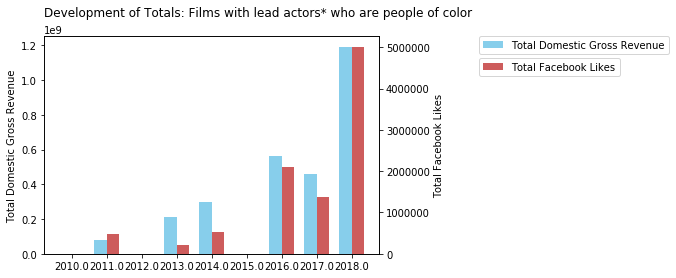

saved to  graphs/bar_year_gross_likes_total_w.png


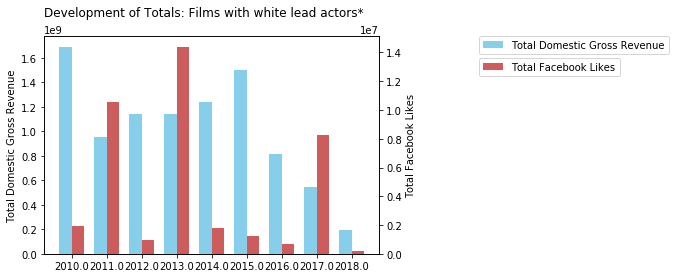

saved to  graphs/bar_year_gross_likes_total_f.png


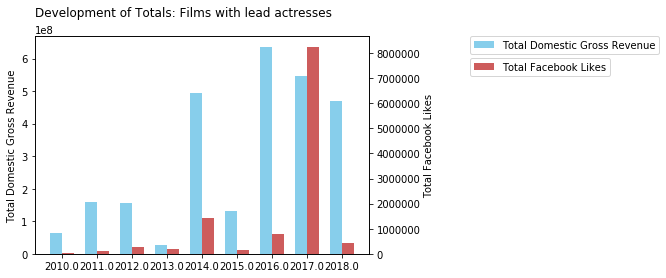

saved to  graphs/bar_year_gross_likes_total_m.png


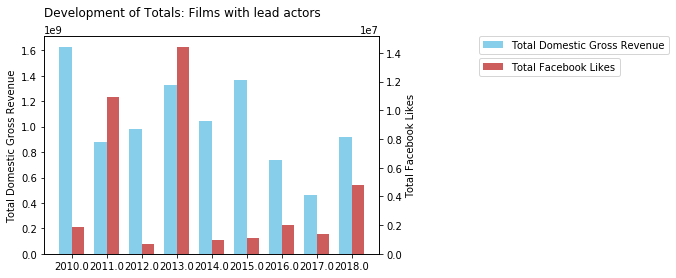

saved to  graphs/bar_year_gross_likes_total_fp.png


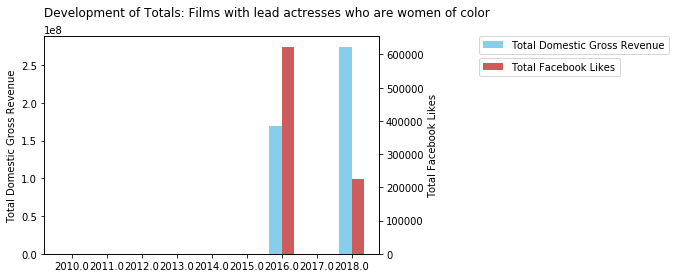

saved to  graphs/bar_year_gross_likes_total_fw.png


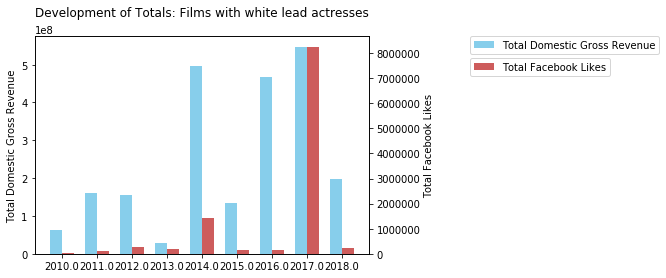

saved to  graphs/bar_year_gross_likes_total_mp.png


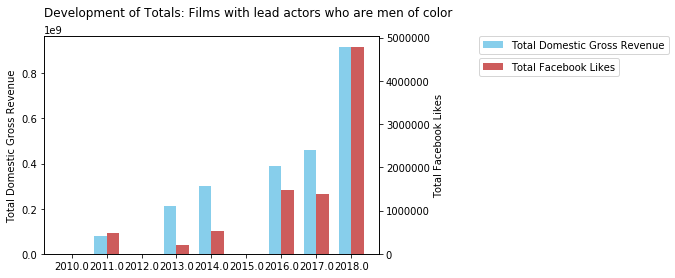

saved to  graphs/bar_year_gross_likes_total_mw.png


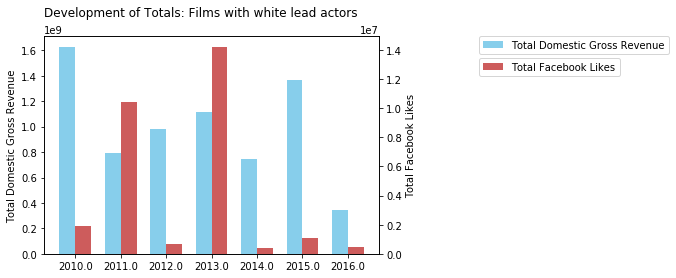

In [21]:
def create_bar_plots_development_totals():
    # Creating bar charts for all top categories
    vis_bar(title='Development of Totals: Films with lead actors* who are people of color', filename='bar_year_gross_likes_total_p', x_axis=movies_p_sum_by_year['title_year'], y_axis1=movies_p_sum_by_year['gross'], y_label1='Total Domestic Gross Revenue', y_axis2=movies_p_sum_by_year['movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Totals: Films with white lead actors*', filename='bar_year_gross_likes_total_w', x_axis=movies_w_sum_by_year['title_year'], y_axis1=movies_w_sum_by_year['gross'], y_label1='Total Domestic Gross Revenue', y_axis2=movies_w_sum_by_year['movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Totals: Films with lead actresses', filename='bar_year_gross_likes_total_f', x_axis=movies_f_sum_by_year['title_year'], y_axis1=movies_f_sum_by_year['gross'], y_label1='Total Domestic Gross Revenue', y_axis2=movies_f_sum_by_year['movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Totals: Films with lead actors', filename='bar_year_gross_likes_total_m', x_axis=movies_m_sum_by_year['title_year'], y_axis1=movies_m_sum_by_year['gross'], y_label1='Total Domestic Gross Revenue', y_axis2=movies_m_sum_by_year['movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)
    
    # Creating bar charts for all sub categories
    vis_bar(title='Development of Totals: Films with lead actresses who are women of color', filename='bar_year_gross_likes_total_fp', x_axis=movies_fp_sum_by_year['title_year'], y_axis1=movies_fp_sum_by_year['gross'], y_label1='Total Domestic Gross Revenue', y_axis2=movies_fp_sum_by_year['movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Totals: Films with white lead actresses', filename='bar_year_gross_likes_total_fw', x_axis=movies_fw_sum_by_year['title_year'], y_axis1=movies_fw_sum_by_year['gross'], y_label1='Total Domestic Gross Revenue', y_axis2=movies_fw_sum_by_year['movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Totals: Films with lead actors who are men of color', filename='bar_year_gross_likes_total_mp', x_axis=movies_mp_sum_by_year['title_year'], y_axis1=movies_mp_sum_by_year['gross'], y_label1='Total Domestic Gross Revenue', y_axis2=movies_mp_sum_by_year['movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Totals: Films with white lead actors', filename='bar_year_gross_likes_total_mw', x_axis=movies_mw_sum_by_year['title_year'], y_axis1=movies_mw_sum_by_year['gross'], y_label1='Total Domestic Gross Revenue', y_axis2=movies_mw_sum_by_year['movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)

create_bar_plots_development_totals()

saved to  graphs/bar_year_gross_likes_mean_p.png


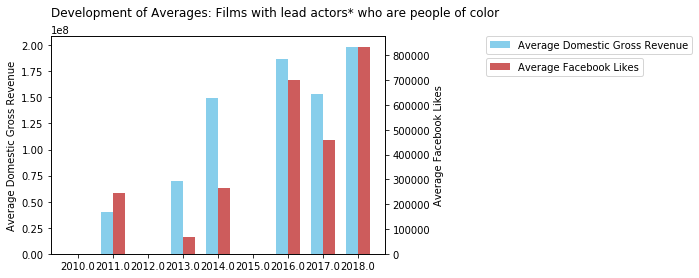

saved to  graphs/bar_year_gross_likes_mean_w.png


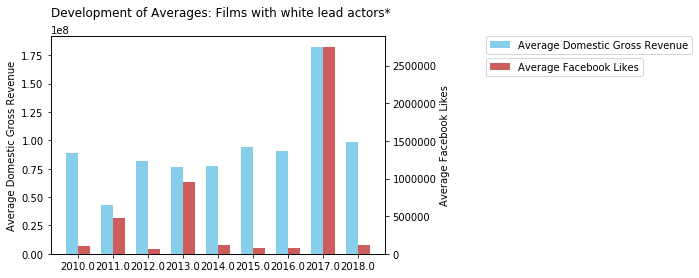

saved to  graphs/bar_year_gross_likes_mean_f.png


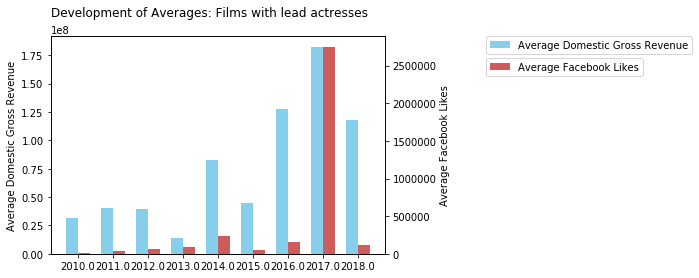

saved to  graphs/bar_year_gross_likes_mean_m.png


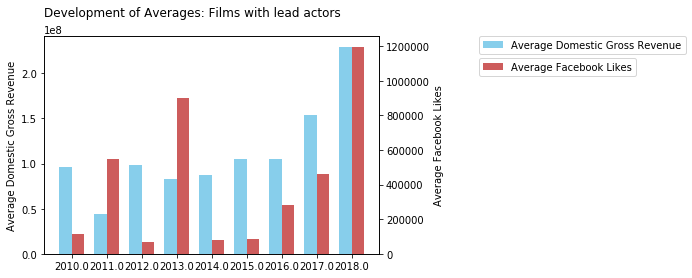

saved to  graphs/bar_year_gross_likes_mean_fp.png


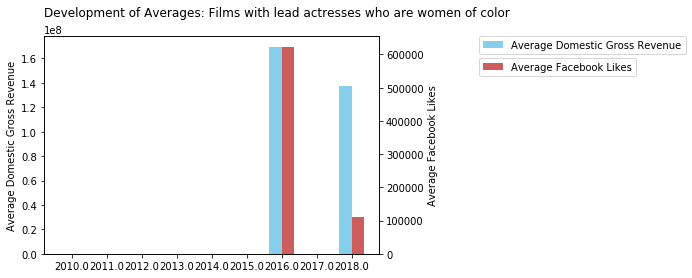

saved to  graphs/bar_year_gross_likes_mean_fw.png


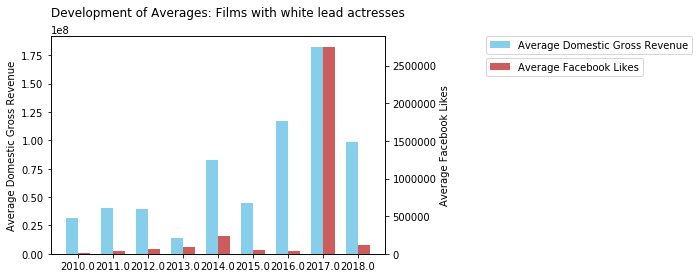

saved to  graphs/bar_year_gross_likes_mean_mp.png


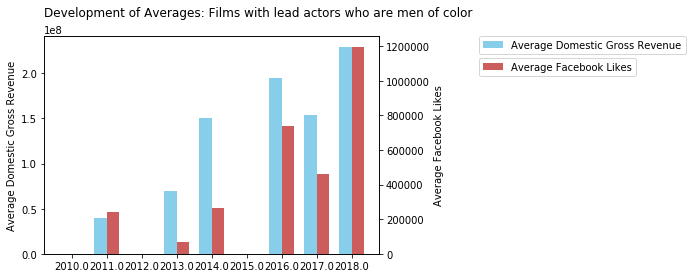

saved to  graphs/bar_year_gross_likes_mean_mw.png


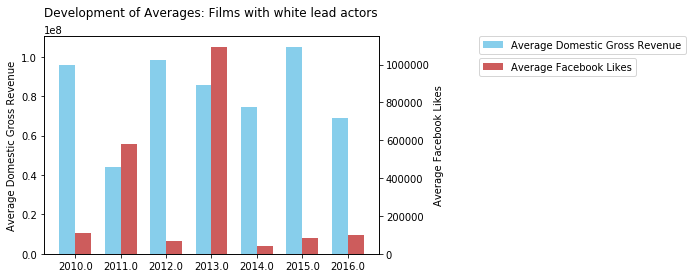

In [22]:
def create_bar_plots_development_means():
    # Creating bar charts for all top categories
    vis_bar(title='Development of Averages: Films with lead actors* who are people of color', filename='bar_year_gross_likes_mean_p', x_axis=movies_p_mean_by_year['title_year'], y_axis1=movies_p_mean_by_year['gross'], y_label1='Average Domestic Gross Revenue', y_axis2=movies_p_mean_by_year['movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Averages: Films with white lead actors*', filename='bar_year_gross_likes_mean_w', x_axis=movies_w_mean_by_year['title_year'], y_axis1=movies_w_mean_by_year['gross'], y_label1='Average Domestic Gross Revenue', y_axis2=movies_w_mean_by_year['movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Averages: Films with lead actresses', filename='bar_year_gross_likes_mean_f', x_axis=movies_f_mean_by_year['title_year'], y_axis1=movies_f_mean_by_year['gross'], y_label1='Average Domestic Gross Revenue', y_axis2=movies_f_mean_by_year['movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Averages: Films with lead actors', filename='bar_year_gross_likes_mean_m', x_axis=movies_m_mean_by_year['title_year'], y_axis1=movies_m_mean_by_year['gross'], y_label1='Average Domestic Gross Revenue', y_axis2=movies_m_mean_by_year['movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)
    
    # Creating bar charts for all sub categories
    vis_bar(title='Development of Averages: Films with lead actresses who are women of color', filename='bar_year_gross_likes_mean_fp', x_axis=movies_fp_mean_by_year['title_year'], y_axis1=movies_fp_mean_by_year['gross'], y_label1='Average Domestic Gross Revenue', y_axis2=movies_fp_mean_by_year['movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Averages: Films with white lead actresses', filename='bar_year_gross_likes_mean_fw', x_axis=movies_fw_mean_by_year['title_year'], y_axis1=movies_fw_mean_by_year['gross'], y_label1='Average Domestic Gross Revenue', y_axis2=movies_fw_mean_by_year['movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Averages: Films with lead actors who are men of color', filename='bar_year_gross_likes_mean_mp', x_axis=movies_mp_mean_by_year['title_year'], y_axis1=movies_mp_mean_by_year['gross'], y_label1='Average Domestic Gross Revenue', y_axis2=movies_mp_mean_by_year['movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Development of Averages: Films with white lead actors', filename='bar_year_gross_likes_mean_mw', x_axis=movies_mw_mean_by_year['title_year'], y_axis1=movies_mw_mean_by_year['gross'], y_label1='Average Domestic Gross Revenue', y_axis2=movies_mw_mean_by_year['movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)

create_bar_plots_development_means()

In [23]:
#Part 3: calculate total and average domestic gross revenue and fb likes for each top category and sub category 
#and make a dataframe from it
#columns: CATEGORY | total fb likes | average fb likes | total domestic gross revenue | average domestic gross revenue 
#categories: 
# df 1 g: M, F, 
# df 2 r: W, P; 
# df 3 gr: MW, MP, FW, FP
def sumAndAvg(col1, col2):
    row = [0,0,0,0]
    i = 0
    for col in [col1, col2]:
        row[i] = col.sum()
        i+=1
        row[i] = col.mean()
        i+=1
    return row

def get_sum_and_averages():
    dfs = [movies_m, movies_f, movies_w, movies_p, movies_mw, movies_mp, movies_fw, movies_fp]

    columns=['total_gross', 'average_gross', 'total_movie_facebook_likes', 'average_movie_facebook_likes']
    categories = ['m', 'f', 'w', 'p', 'mw', 'mp', 'fw', 'fp']
    rows = [sumAndAvg(df['gross'], df['movie_facebook_likes']) for df in dfs]

    return pd.DataFrame(rows, columns=columns).assign(category=categories)

In [24]:
#Part 4: Get own dataframes for each category: gender, race, race and gender
statisticalResults = get_sum_and_averages()
g = statisticalResults[(statisticalResults.category == 'm') | (statisticalResults.category == 'f')]
r = statisticalResults[(statisticalResults.category == 'w') | (statisticalResults.category == 'p')]
gr = statisticalResults[(statisticalResults.category == 'mw') | (statisticalResults.category == 'fw') | (statisticalResults.category == 'mp') | (statisticalResults.category == 'fp')]

saved to  graphs/bar_g_gross_likes_total.png


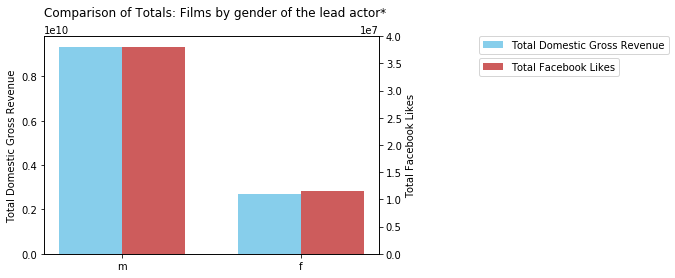

saved to  graphs/bar_r_gross_likes_total.png


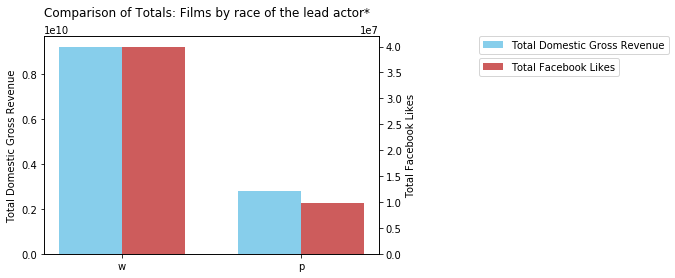

saved to  graphs/bar_gr_gross_likes_total.png


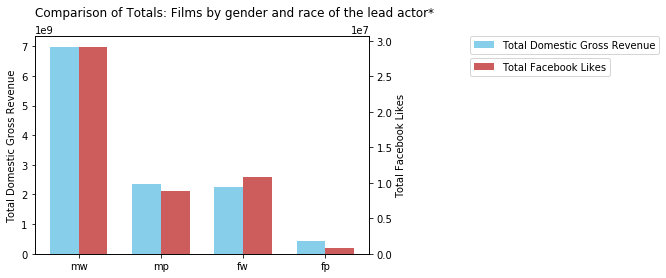

saved to  graphs/bar_g_gross_likes_average.png


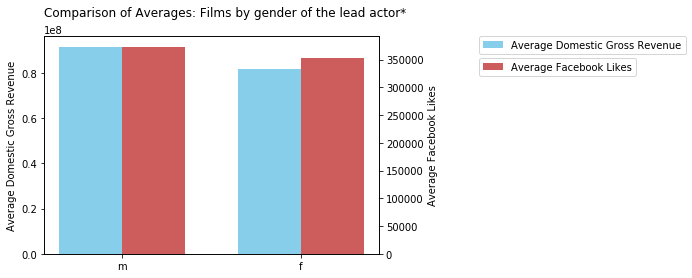

saved to  graphs/bar_r_gross_likes_average.png


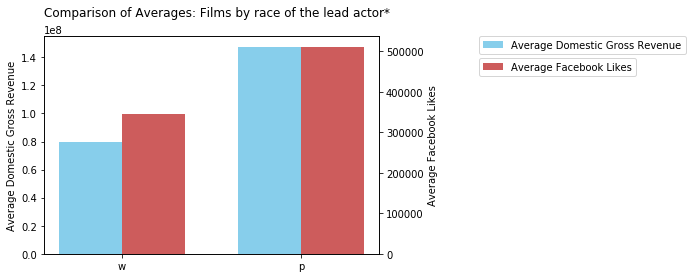

saved to  graphs/bar_gr_gross_likes_average.png


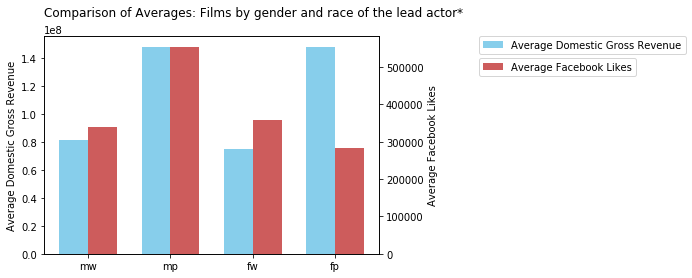

In [25]:
def create_bar_plots_comparison_totals():
    #Part 5a: Compare total dgr & fb likes per categories with bar diagrams
    vis_bar(title='Comparison of Totals: Films by gender of the lead actor*', filename='bar_g_gross_likes_total', x_axis=g['category'], y_axis1=g['total_gross'], y_label1='Total Domestic Gross Revenue', y_axis2=g['total_movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Comparison of Totals: Films by race of the lead actor*', filename='bar_r_gross_likes_total', x_axis=r['category'], y_axis1=r['total_gross'], y_label1='Total Domestic Gross Revenue', y_axis2=r['total_movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)

    vis_bar(title='Comparison of Totals: Films by gender and race of the lead actor*', filename='bar_gr_gross_likes_total', x_axis=gr['category'], y_axis1=gr['total_gross'], y_label1='Total Domestic Gross Revenue', y_axis2=gr['total_movie_facebook_likes'], y_label2='Total Facebook Likes', horizontal_xlabels=True)

def create_bar_plots_comparison_averages():
    #Part 6a: Compare average dgr & fb likes per categories
    vis_bar(title='Comparison of Averages: Films by gender of the lead actor*', filename='bar_g_gross_likes_average', x_axis=g['category'], y_axis1=g['average_gross'], y_label1='Average Domestic Gross Revenue', y_axis2=g['average_movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)
    vis_bar(title='Comparison of Averages: Films by race of the lead actor*', filename='bar_r_gross_likes_average', x_axis=r['category'], y_axis1=r['average_gross'], y_label1='Average Domestic Gross Revenue', y_axis2=r['average_movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)

    vis_bar(title='Comparison of Averages: Films by gender and race of the lead actor*', filename='bar_gr_gross_likes_average', x_axis=gr['category'], y_axis1=gr['average_gross'], y_label1='Average Domestic Gross Revenue', y_axis2=gr['average_movie_facebook_likes'], y_label2='Average Facebook Likes', horizontal_xlabels=True)

create_bar_plots_comparison_totals()
create_bar_plots_comparison_averages()

In [26]:
#Part 7a: Function for making a pie chart
#https://pythonspot.com/matplotlib-pie-chart/
#https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
def vis_pie(title, legend, value, label, **keyword_parameters):
    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))

    wedges, texts, autotexts = ax.pie(value, autopct='%1.1f%%',
                                      textprops=dict(color="w"))

    ax.legend(wedges, legend,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title(label)

    if('filename' not in keyword_parameters):
        path='graphs/' + title.replace(" ", "").replace("*", "").replace(":", "") + '.png'
    else:
        path='graphs/' + keyword_parameters['filename'] + '.png'
    
    fig.savefig(path, transparent=True, bbox_inches='tight') #save the graph
    print('saved to ', path)
    
    plt.show()

In [27]:
#Part 7: Compare total dgr, fb likes, and IMDB Score per categories with pie diagrams
def create_pie_plots():
    vis_pie(title='Comparison of Totals: Film Revenue by gender of the lead actor*', filename='pie_g_gross_total', legend=g['category'], value=g['total_gross'], label='Total Domestic Gross Revenue')
    vis_pie(title='Comparison of Totals: Film Likes by gender of the lead actor*', filename='pie_g_likes_total', legend=g['category'], value=g['total_movie_facebook_likes'], label='Total Facebook Likes')
    
    vis_pie(title='Comparison of Totals: Film Revenue by race of the lead actor*', filename='pie_r_gross_total', legend=r['category'], value=r['total_gross'], label='Total Domestic Gross Revenue')
    vis_pie(title='Comparison of Totals: Film Likes by race of the lead actor*', filename='pie_r_likes_total', legend=r['category'], value=r['total_movie_facebook_likes'], label='Total Facebook Likes')
    
    vis_pie(title='Comparison of Totals: Film Revenue by gender and race of the lead actor*', filename='pie_gr_gross_total', legend=gr['category'], value=gr['total_gross'], label='Total Domestic Gross Revenue')
    vis_pie(title='Comparison of Totals: Film Likes by gender and race of the lead actor*', filename='pie_gr_likes_total', legend=gr['category'], value=gr['total_movie_facebook_likes'], label='Total Facebook Likes')

In [28]:
#Part 8: Create splatter diagrams
def vis_splat(x_axis, y_axis, ylabel, title, **keyword_parameters):
    fig, ax = plt.subplots()
    plt.plot(x_axis, y_axis, 'o', alpha=.5, label=ylabel)
    #https://matplotlib.org/users/legend_guide.html
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(label=title, pad=20.0, loc='left')
    
    if('filename' not in keyword_parameters):
        path='graphs/' + title.replace(" ", "").replace("*", "").replace(":", "") + '.png'
    else:
        path='graphs/' + keyword_parameters['filename'] + '.png'
    
    fig.savefig(path, transparent=True, bbox_inches='tight') #save the graph
    print('saved to ', path)
    
    plt.show()


saved to  graphs/scatter_year_gross_f.png


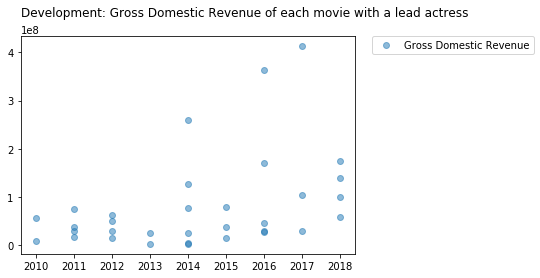

saved to  graphs/scatter_year_gross_m.png


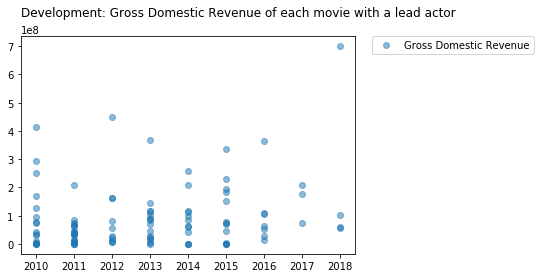

saved to  graphs/scatter_year_gross_w.png


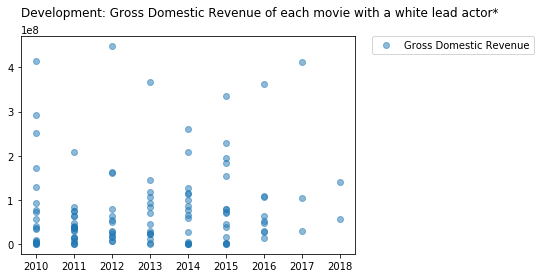

saved to  graphs/scatter_year_gross_n.png


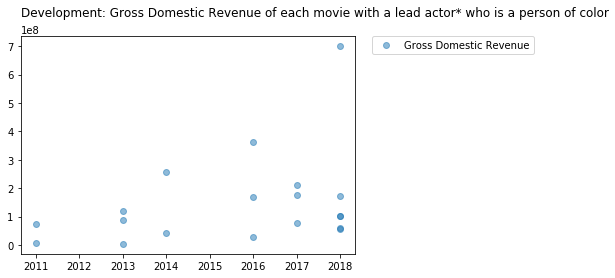

saved to  graphs/scatter_year_gross_mw.png


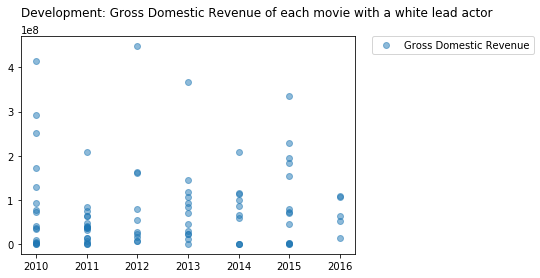

saved to  graphs/scatter_year_gross_mp.png


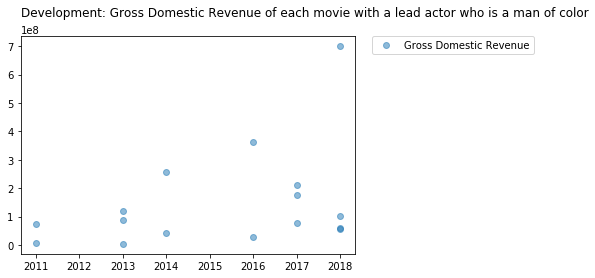

saved to  graphs/scatter_year_gross_fw.png


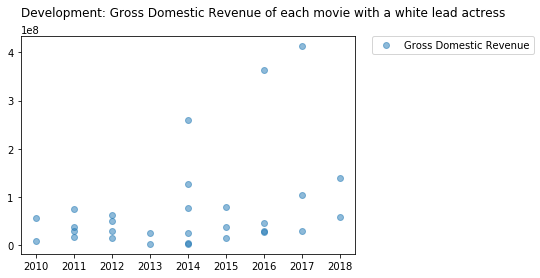

saved to  graphs/scatter_year_gross_fp.png


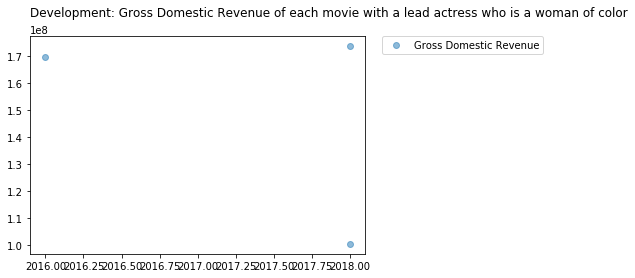

saved to  graphs/scatter_year_likes_f.png


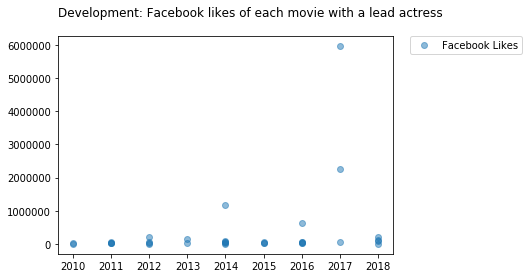

saved to  graphs/scatter_year_likes_m.png


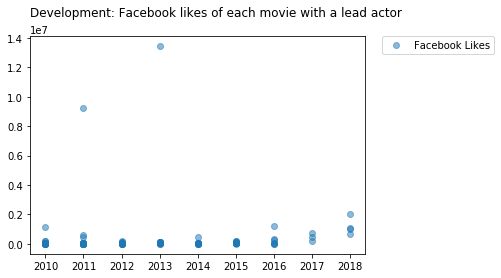

saved to  graphs/scatter_year_likes_w.png


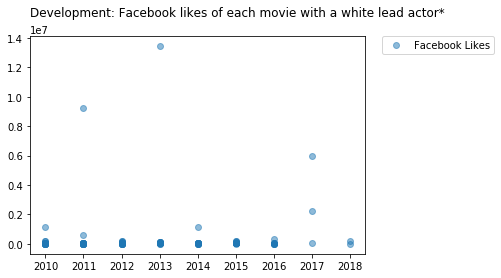

saved to  graphs/scatter_year_likes_p.png


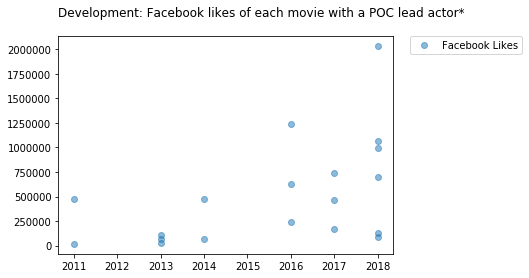

saved to  graphs/scatter_year_likes_mw.png


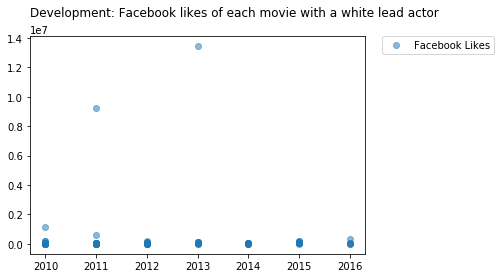

saved to  graphs/scatter_year_likes_mp.png


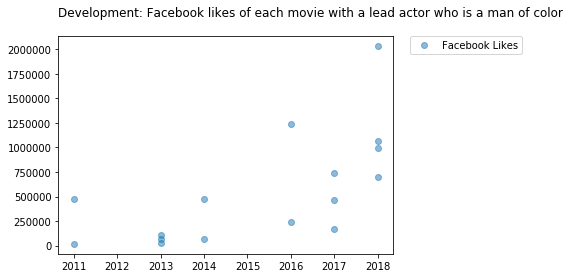

saved to  graphs/scatter_year_likes_fw.png


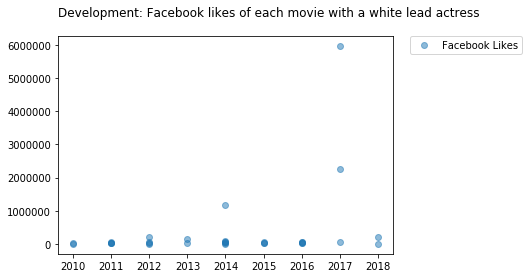

saved to  graphs/scatter_year_likes_fp.png


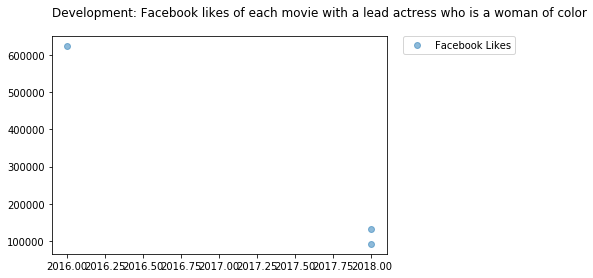

saved to  graphs/scatter_g_gross.png


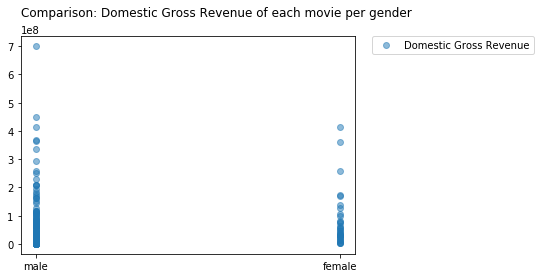

saved to  graphs/scatter_g_likes.png


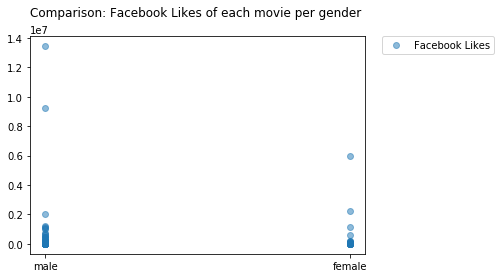

saved to  graphs/scatter_r_gross.png


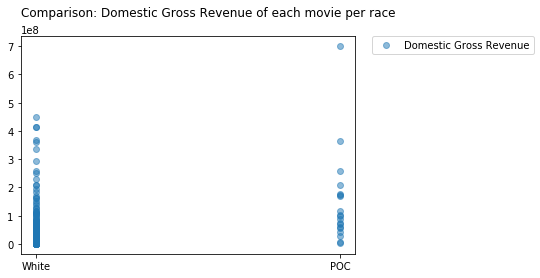

saved to  graphs/scatter_r_likes.png


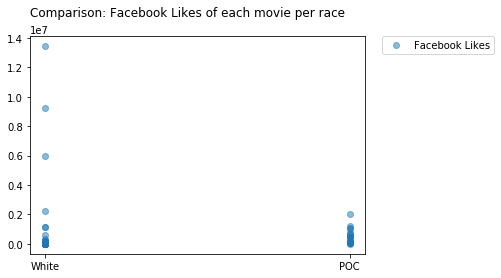

saved to  graphs/scatter_gr_gross.png


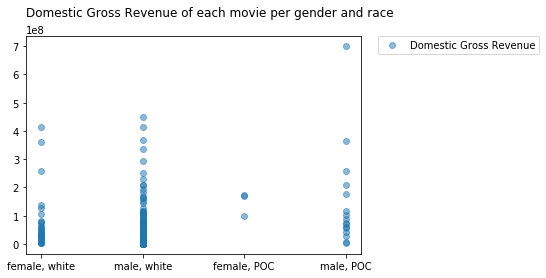

saved to  graphs/scatter_gr_likes.png


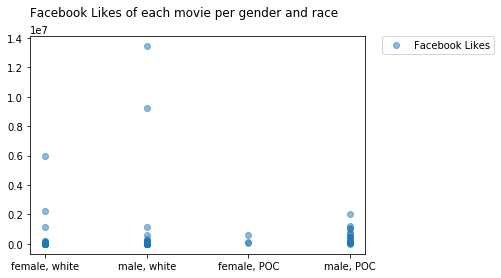

In [29]:
def create_scatter_plots():
    # a) x = year of movie, y = gross (each movie) (for female)
    # x = year of movie, y = gross (each movie) (for male)
    # x = year of movie, y = gross (each movie) (for white)
    # x = year of movie, y = gross (each movie) (for POC)
    # x = year of movie, y = gross (each movie) (for mw, mp, fw, fp)
    vis_splat(movies_f["title_year"], movies_f["gross"], "Gross Domestic Revenue", "Development: Gross Domestic Revenue of each movie with a lead actress", filename="scatter_year_gross_f")
    vis_splat(movies_m["title_year"], movies_m["gross"], "Gross Domestic Revenue", "Development: Gross Domestic Revenue of each movie with a lead actor", filename="scatter_year_gross_m")
    vis_splat(movies_w["title_year"], movies_w["gross"], "Gross Domestic Revenue", "Development: Gross Domestic Revenue of each movie with a white lead actor*", filename="scatter_year_gross_w")
    vis_splat(movies_p["title_year"], movies_p["gross"], "Gross Domestic Revenue", "Development: Gross Domestic Revenue of each movie with a lead actor* who is a person of color", filename="scatter_year_gross_n")
    
    vis_splat(movies_mw["title_year"], movies_mw["gross"], "Gross Domestic Revenue", "Development: Gross Domestic Revenue of each movie with a white lead actor", filename="scatter_year_gross_mw")
    vis_splat(movies_mp["title_year"], movies_mp["gross"], "Gross Domestic Revenue", "Development: Gross Domestic Revenue of each movie with a lead actor who is a man of color", filename="scatter_year_gross_mp")
    vis_splat(movies_fw["title_year"], movies_fw["gross"], "Gross Domestic Revenue", "Development: Gross Domestic Revenue of each movie with a white lead actress", filename="scatter_year_gross_fw")
    vis_splat(movies_fp["title_year"], movies_fp["gross"], "Gross Domestic Revenue", "Development: Gross Domestic Revenue of each movie with a lead actress who is a woman of color", filename="scatter_year_gross_fp")
    
    # b) x = year of movie, y = FB likes
    vis_splat(movies_f["title_year"], movies_f["movie_facebook_likes"], "Facebook Likes", "Development: Facebook likes of each movie with a lead actress", filename="scatter_year_likes_f")
    vis_splat(movies_m["title_year"], movies_m["movie_facebook_likes"], "Facebook Likes", "Development: Facebook likes of each movie with a lead actor", filename="scatter_year_likes_m")
    vis_splat(movies_w["title_year"], movies_w["movie_facebook_likes"], "Facebook Likes", "Development: Facebook likes of each movie with a white lead actor*", filename="scatter_year_likes_w")
    vis_splat(movies_p["title_year"], movies_p["movie_facebook_likes"], "Facebook Likes", "Development: Facebook likes of each movie with a POC lead actor*", filename="scatter_year_likes_p")
    
    vis_splat(movies_mw["title_year"], movies_mw["movie_facebook_likes"], "Facebook Likes", "Development: Facebook likes of each movie with a white lead actor", filename="scatter_year_likes_mw")
    vis_splat(movies_mp["title_year"], movies_mp["movie_facebook_likes"], "Facebook Likes", "Development: Facebook likes of each movie with a lead actor who is a man of color", filename="scatter_year_likes_mp")
    vis_splat(movies_fw["title_year"], movies_fw["movie_facebook_likes"], "Facebook Likes", "Development: Facebook likes of each movie with a white lead actress", filename="scatter_year_likes_fw")
    vis_splat(movies_fp["title_year"], movies_fp["movie_facebook_likes"], "Facebook Likes", "Development: Facebook likes of each movie with a lead actress who is a woman of color", filename="scatter_year_likes_fp")
    
    # c) x = gender of lead actor, y = gross (each movie)
    # d) x = gender, y = FB likes
    vis_splat(movies_dataframe_noDuplicates["gender"], movies_dataframe_noDuplicates["gross"], "Domestic Gross Revenue", "Comparison: Domestic Gross Revenue of each movie per gender", filename="scatter_g_gross")
    vis_splat(movies_dataframe_noDuplicates["gender"], movies_dataframe_noDuplicates["movie_facebook_likes"], "Facebook Likes", "Comparison: Facebook Likes of each movie per gender", filename="scatter_g_likes")
    
    # e) x = race, y = gross
    # e) x = race, y = fb likes
    vis_splat(movies_dataframe_noDuplicates["race_simple"], movies_dataframe_noDuplicates["gross"], "Domestic Gross Revenue", "Comparison: Domestic Gross Revenue of each movie per race", filename="scatter_r_gross")
    vis_splat(movies_dataframe_noDuplicates["race_simple"], movies_dataframe_noDuplicates["movie_facebook_likes"], "Facebook Likes", "Comparison: Facebook Likes of each movie per race", filename="scatter_r_likes")

    # f) x = gender and race, y = gross
    # g) x = gender and race, y = FB likes  
    # commented out because this doesn't have to run each time
    vis_splat(movies_with_subcat["subcat"], movies_with_subcat["gross"], "Domestic Gross Revenue", "Domestic Gross Revenue of each movie per gender and race", filename="scatter_gr_gross")
    vis_splat(movies_with_subcat["subcat"], movies_with_subcat["movie_facebook_likes"], "Facebook Likes", "Facebook Likes of each movie per gender and race", filename="scatter_gr_likes")

create_scatter_plots()

saved to  graphs/scatter_g_likes_no-outliers.png


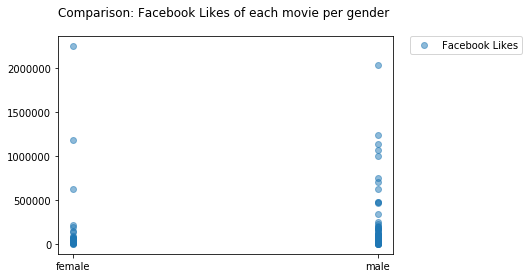

saved to  graphs/scatter_r_likes_no-outliers.png


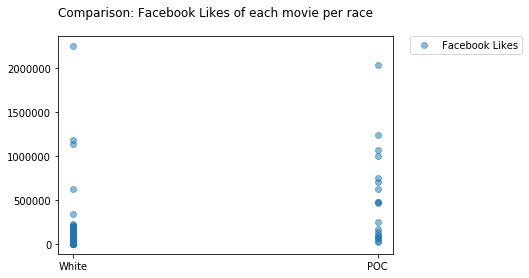

saved to  graphs/scatter_gr_likes_no-outliers.png


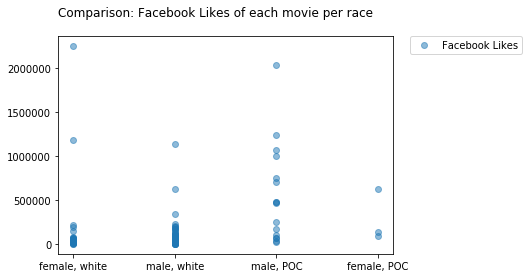

In [30]:
# Part 9: Remove statistical outliers and create new graphs
#Comparison Male - Female without outliers / likes
toShow = movies_dataframe_noDuplicates.sort_values(by='movie_facebook_likes').query('movie_facebook_likes < 5961116')
vis_splat(toShow["gender"], toShow["movie_facebook_likes"], "Facebook Likes", "Comparison: Facebook Likes of each movie per gender", filename="scatter_g_likes_no-outliers")

#Comparison White - POC without outliers / likes
toShow = movies_dataframe_noDuplicates.sort_values(by='movie_facebook_likes').query('movie_facebook_likes < 5961116')
vis_splat(toShow["race_simple"], toShow["movie_facebook_likes"], "Facebook Likes", "Comparison: Facebook Likes of each movie per race", filename="scatter_r_likes_no-outliers")

#Comparison subcats without outliers / likes
toShow = movies_with_subcat.sort_values(by='movie_facebook_likes').query('movie_facebook_likes < 5961116')
vis_splat(toShow["subcat"], toShow["movie_facebook_likes"], "Facebook Likes", "Comparison: Facebook Likes of each movie per race", filename="scatter_gr_likes_no-outliers")
